# 🏠 House Price Prediction Lab - Solution

**Project Description**:

The goal of this project is to predict house price based on real estate features extracted for houses in Bengaluru. The major sequence of steps in the coding process are listed below:

1.   Load and clean up the data.
2.   Analyze the features (*ordinal, categorical*, and *continuous*) for missingness, correct data type association, and distribution.
3.   Spit the data into train and test sets..
4.   Build an ML pipeline (*encoder -> imputer -> regression module*) for the train set by specifying seperate ecoding and imputing steps (if needed) for ordinal, categorical, and continuous features.
5.   Train the ML pipeline on the train set and apply it for prediction on the test set.
6.   Report performance metrics

---

Import libraries

---

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline

## Pipeline module
from sklearn.pipeline import Pipeline

## Scaling, encoding, and imputation libraries
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Column trandformation library
from sklearn.compose import ColumnTransformer

## Train-test, cross-validation, and grid search modules
from sklearn.model_selection import train_test_split

## Cross-validation and grid search modules
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score

## Regression modules
from sklearn import linear_model

## Performance metrics modules
from sklearn.metrics import mean_squared_error, r2_score

## Model serialization module
import joblib

---

Mount Google Drive if running in Colab

---

In [2]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2025MAHE/House Price Project/'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = '../data/'

---

Load bengaluru house price data

---

In [3]:
## Load Bengaluru house price data
file = DATA_DIR + 'houseprices.csv'
df= pd.read_csv(file, header = 0)

print('Bengaluru house price dataset')
print('-----------')
print('Initial number of samples = %d'%(df.shape[0]))
print('Initial number of features = %d\n'%(df.shape[1]))
df.head(5)

Bengaluru house price dataset
-----------
Initial number of samples = 225
Initial number of features = 8



,locality,area,rent,price_per_sqft,facing,BHK,bathrooms,parking
0,BTM Layout,565.0,20060.0,6195.0,North-West,1,1,Bike
1,BTM Layout,1837.0,97434.0,9254.0,East,3,3,Bike and Car
2,BTM Layout,1280.0,54448.0,7422.0,East,2,2,Car
3,BTM Layout,2220.0,117000.0,9234.0,North,3,3,Bike and Car
4,BTM Layout,1113.0,34388.0,5391.0,East,2,2,Bike and Car


---

Plot percentage of missing values (NaNs) for each feature

---

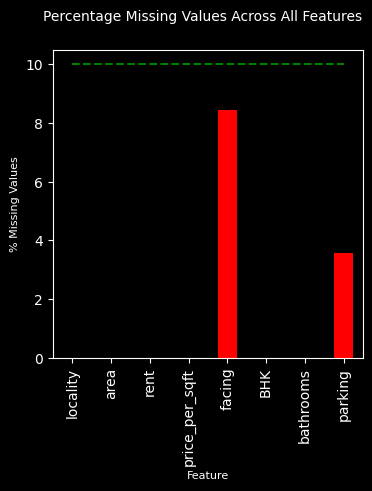

In [4]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 10 # we will remove features missing in more than cutoff% of the samples
fig = plt.figure(figsize=(4, 4))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 10)
plt.xlabel('Feature', fontsize = 8)
plt.ylabel('% Missing Values', fontsize = 8);

---

Create lists of ordinal, categorical, and continuous features

---

In [5]:
## Create lists of ordinal, categorical, and continuous features
ordinal_features = ['BHK', 'bathrooms']
categorical_features = ['locality', 'facing', 'parking']
continuous_features = (df.drop(ordinal_features, axis = 1)).drop(categorical_features, axis = 1).columns.tolist()

# Remove target variable from continuous features
continuous_features.remove('price_per_sqft')

In [6]:
#this is object datatype
df.columns

Index(['locality', 'area', 'rent', 'price_per_sqft', 'facing', 'BHK',
       'bathrooms', 'parking'],
      dtype='object')

---

Treat "missingness" as another level in the categorical variables

---

In [7]:
# Replace NaN with 'Missing' in categorical columns
df[categorical_features] = df[categorical_features].fillna('Missing')

---

Assign 'category' datatype to ordinal and categorical columns

---

In [8]:
## Assign 'category' datatype to ordinal and categorical columns
print(df.dtypes)
df[ordinal_features + categorical_features] = df[ordinal_features + categorical_features].astype('category')
print('----')
df.dtypes

locality           object
area              float64
rent              float64
price_per_sqft    float64
facing             object
BHK                 int64
bathrooms           int64
parking            object
dtype: object
----


locality          category
area               float64
rent               float64
price_per_sqft     float64
facing            category
BHK               category
bathrooms         category
parking           category
dtype: object

---

Print unique values in each ordinal and categorical features

---

In [9]:
## Print unique values in each ordinal and categorical features
print(df[ordinal_features + categorical_features].nunique())
print('\nUnique values in ordinal and categorical features')
print('---------------------------------------------------')
unique_values = {col:list(df[col].unique()) for col in ordinal_features + categorical_features}
for key, value in unique_values.items():
  print(key,value)

BHK           4
bathrooms    10
locality      9
facing        8
parking       4
dtype: int64

Unique values in ordinal and categorical features
---------------------------------------------------
BHK [1, 3, 2, 4]
bathrooms [1, 3, 2, 5, 13, 4, 26, 16, 6, 14]
locality ['BTM Layout', 'Attibele', 'K R Puram ', 'Marathahalli', 'Indiranagar', 'Electronic City', 'Yalahanka', 'Malleshwaram', 'Jayanagar']
facing ['North-West', 'East', 'North', 'West', 'North-East', 'South-East', 'South', 'Missing']
parking ['Bike', 'Bike and Car', 'Car', 'Missing']


---

Build pipeline for ordinal, categorical, and continuous features

---

In [10]:
## Build pipeline for ordinal, categorical, and continuous features

# Pipeline object for ordinal features
ordinal_transformer = Pipeline(steps = [('ordinalenc', OrdinalEncoder())])

# Pipeline object for categorical (features
categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])
# Use the following if missing values are to be imputed
# categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')), ('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', StandardScaler())])

# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features),
                                                 ('categorical', categorical_transformer, categorical_features),
                                                 ('ordinal', ordinal_transformer, ordinal_features)
                                                ],
                                 remainder = 'passthrough'
                                 )

# Define a regressor object
regressor = linear_model.LinearRegression()

# Define the entire classification model pipeline
model_pipeline = Pipeline(steps = [('preprocessor', preprocessor), ('Regressor', regressor)])

---

Train-test split of the dataset

---

In [11]:
## Train and test split of the data
X = df.drop('price_per_sqft', axis = 1)
y = df['price_per_sqft']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    random_state = 1)
print(f'# training samples = {(X_train.shape[0])}, # test samples = {X_test.shape[0]}')

# training samples = 202, # test samples = 23


---

Fit the pipeline on the train data and test on the test data

---

In [12]:
## Fit the model pipeline on the train data and test on the test data
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
print(f'Root Mean Squared Error = {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'r2_score = {r2_score(y_test, y_pred)}')

Root Mean Squared Error = 1218.040109472817
r2_score = 0.8304453423918852


---

Save model

---

In [13]:
# Save model
joblib.dump(model_pipeline, '../model.pkl')

['../model.pkl']